## Import Library

In [177]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import unicodedata
import os
import yfinance as yf
import math
import warnings
warnings.filterwarnings("ignore")
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from matplotlib.dates import DateFormatter
import statistics
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder,label_binarize
from textblob import TextBlob, Word
from datetime import datetime, timedelta
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

In [178]:
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/pushpendrammishra/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pushpendrammishra/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pushpendrammishra/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pushpendrammishra/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pushpendrammishra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Web scrapping of news   

In [179]:
 
work_directory = '/Users/pushpendrammishra/Desktop/ Stock sentimental analysis'

In [180]:
stock_tweet_path=work_directory+"/stock_tweets.csv"
stock_data_path=work_directory+"/stock_yfinance_data.csv"

**From yahoo finance for below ticker**

In [181]:
tickers = ['TSLA' ,'SMCI', 'AMZN', 'AVGO' ,'ALB' ,'MSFT' ,'META', 'NFLX' ,'NVDA']

In [182]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time

# Setup Selenium WebDriver
service = Service(ChromeDriverManager().install())
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument("--headless")  # Enable headless mode
chrome_options.add_argument("--no-sandbox")
chrome_options.add_argument("--disable-dev-shm-usage")
driver = webdriver.Chrome(service=service, options=chrome_options)


def last_11_months(time_text):
    if 'months' in time_text:
        months = int(time_text.split()[0])
        return months <= 11
    return True

# Initialize an empty DataFrame to collect all news
headlines = pd.DataFrame()

for ticker in tickers:
    url = f'https://finance.yahoo.com/quote/{ticker}/news/'
    driver.get(url)
    time.sleep(4)
    print(f'Collecting news related to {ticker}')
    previous_height = driver.execute_script('return document.body.scrollHeight')
    count = 0
    news = []
    
    while True:
        content_divs = driver.find_elements(By.CSS_SELECTOR, 'div.content.svelte-w27v8j')
        
        latest_time_text = ''
        for content_div in content_divs:
            try:
                a_tag = content_div.find_element(By.CSS_SELECTOR, 'a.subtle-link.fin-size-small.titles.noUnderline.svelte-wdkn18')
                title = a_tag.get_attribute('title') if a_tag else None
                
                publishing_div = content_div.find_element(By.CSS_SELECTOR, 'div.publishing.font-condensed.svelte-1k3af9g')
                time_text = publishing_div.text.split('•')[-1].strip() if publishing_div else None
                latest_time_text = time_text
                if latest_time_text and last_12_months(latest_time_text):
                    news.append({'Date': time_text, 'Headline': title, 'Stock Name': ticker})
            except Exception as e:
                print(f"Error extracting data: {e}")

        driver.execute_script('window.scrollTo(0, document.body.scrollHeight)')
        time.sleep(4)
        new_height = driver.execute_script('return document.body.scrollHeight')
        
        if new_height == previous_height:
            count += 1
            if count > 4:
                break
        else:
            previous_height = new_height
            count = 0
        
        if latest_time_text and not last_11_months(latest_time_text):
            break
    
    df_news = pd.DataFrame(news)
    
    if not df_news.empty:
        print(f'Starting news related to {ticker} is {df_news["Date"].iloc[0]}')
        print(f'Ending news related to {ticker} is {df_news["Date"].iloc[-1]}')
        print('Dataset size is ', df_news.shape[0])
        headlines = pd.concat([headlines, df_news], ignore_index=True)

# Close the WebDriver
driver.quit()

In [183]:
# Function to convert relative time text to actual date
def convert_to_date(time_text):
    now = datetime.now()
    if time_text == 'yesterday':
        return now - timedelta(days=1)
    if time_text == 'last month':
        return now - timedelta(days=30)
    if 'minute' in time_text:
        minutes = int(time_text.split()[0])
        return now - timedelta(minutes=minutes)
    elif 'hour' in time_text:
        hours = int(time_text.split()[0])
        return now - timedelta(hours=hours)
    elif 'day' in time_text:
        days = int(time_text.split()[0])
        return now - timedelta(days=days)
    elif 'week' in time_text:
        weeks = int(time_text.split()[0])
        return now - timedelta(weeks=weeks)
    elif 'month' in time_text:
        months = int(time_text.split()[0])
        return now - timedelta(days=30*months)
    elif 'today' in time_text.lower():
        return now
    else:
        return None
headlines['Date'] = headlines['Date'].apply(convert_to_date)

**From api.nytimes for AAPL**

In [184]:
import requests
import time

def fetch_news(year, month, api_key):
    url = f"https://api.nytimes.com/svc/archive/v1/{year}/{month}.json?api-key={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        articles = data['response']['docs']
        return articles
    else:
        print(f"Failed to fetch data for {year}-{month}: {response.status_code}")
        return []

# Initialize lists for headlines and dates
all_headlines = []
all_dates = []

# API key
api_key = 'Z7LiuLGnozS868StkM3QcbQhsJA8acDt'

# Fetch data for each year from 2010 to 2024
for year in range(2020, 2024):
    for month in range(1, 13):
        print(f"Fetching data for {year}-{month}")
        try:
            articles = fetch_news(year, month, api_key)
            if articles:
                all_headlines.extend([article['headline']['main'] for article in articles])
                all_dates.extend([article['pub_date'] for article in articles])
            # Sleep to respect API rate limits
            time.sleep(6)  # Adjust sleep time as needed based on API rate limits
        except Exception as e:
            print(f"Error fetching data for {year}-{month}: {e}")


 


In [185]:
# Create a DataFrame
df = pd.DataFrame({'Date': all_dates, 'Headline': all_headlines})

# Convert datetime column to datetime format
df['Date'] = pd.to_datetime(df['Date'])
df['Stock Name']='AAPL'
print('data extracted')

In [186]:
headlines = pd.concat([headlines, df], ignore_index=True)


In [187]:
# Save the collected news to a CSV file
headlines.to_csv(stock_tweet_path, index=False)


## Related stock data

In [188]:
Stock=pd.DataFrame()  # Example ticker symbol for Apple
start_date = "2023-07-01"  # Specify start date
end_date = "2024-06-14"   
dfs = [] 
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date).reset_index()  # Reset index to make 'Date' a column
    data['Stock Name'] = ticker  # Add a column for the ticker symbol
    dfs.append(data)
data=yf.download('AAPL',start='2020-01-01',end='2023-12-30').reset_index()
data['Stock Name']='AAPL'
dfs.append(data)
# Combine all individual dataframes into a single dataframe
Stock = pd.concat(dfs, ignore_index=True)

# Reorder columns as per the desired format
Stock = Stock[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Stock Name']]

 

In [189]:
Stock.head()

In [190]:
Stock['Stock Name'].value_counts()

In [191]:
Stock.shape

In [192]:
Stock.to_csv(stock_data_path, index=False)

## Data

In [193]:
headlines=pd.read_csv(stock_tweet_path)

In [194]:
print(headlines['Stock Name'].unique())

['TSLA' 'SMCI' 'AMZN' 'AVGO' 'ALB' 'MSFT' 'META' 'NFLX' 'NVDA' 'AAPL']


In [195]:
headlines.shape

(214426, 3)

## Sentiment analysis

In [196]:
headlines['polarity_score']=''
headlines['Headline'] = headlines['Headline'].astype(str)
headlines.head()

,Date,Headline,Stock Name,polarity_score
0,2024-06-14 22:48:25.332619,Don't bet against Elon Musk: Dan Ives talks $1...,TSLA,
1,2024-06-14 08:38:25.332639,What Apple Intelligence means for Apple's stoc...,TSLA,
2,2024-06-14 07:38:25.332644,"Elon Musk has been integral to Tesla's growth,...",TSLA,
3,2024-06-14 07:38:25.332647,Tesla's Musk secures $56B pay package after sh...,TSLA,
4,2024-06-14 05:38:25.332650,Is Elon Musk the right fit as Tesla's CEO?,TSLA,


In [197]:
sent_analyze = SentimentIntensityAnalyzer()

# Analyze each tweet and store the compound score
for ind, row in headlines.iterrows():
    headline = row["Headline"]
    sentence_i = unicodedata.normalize("NFKD", headline)
    sent_sent = sent_analyze.polarity_scores(sentence_i)
    headlines.at[ind, "polarity_score"] = sent_sent["compound"]




In [198]:
headlines.head()

,Date,Headline,Stock Name,polarity_score
0,2024-06-14 22:48:25.332619,Don't bet against Elon Musk: Dan Ives talks $1...,TSLA,0.0
1,2024-06-14 08:38:25.332639,What Apple Intelligence means for Apple's stoc...,TSLA,0.4767
2,2024-06-14 07:38:25.332644,"Elon Musk has been integral to Tesla's growth,...",TSLA,0.3818
3,2024-06-14 07:38:25.332647,Tesla's Musk secures $56B pay package after sh...,TSLA,0.2263
4,2024-06-14 05:38:25.332650,Is Elon Musk the right fit as Tesla's CEO?,TSLA,0.3612


In [199]:
headlines["sentiment_label"] = headlines["Headline"].apply(lambda x: "pos" if sent_analyze.polarity_scores(x)["compound"] > 0 else ("neu" if sent_analyze.polarity_scores(x)["compound"] ==0 else "neg"))

In [200]:
headlines.head()

,Date,Headline,Stock Name,polarity_score,sentiment_label
0,2024-06-14 22:48:25.332619,Don't bet against Elon Musk: Dan Ives talks $1...,TSLA,0.0,neu
1,2024-06-14 08:38:25.332639,What Apple Intelligence means for Apple's stoc...,TSLA,0.4767,pos
2,2024-06-14 07:38:25.332644,"Elon Musk has been integral to Tesla's growth,...",TSLA,0.3818,pos
3,2024-06-14 07:38:25.332647,Tesla's Musk secures $56B pay package after sh...,TSLA,0.2263,pos
4,2024-06-14 05:38:25.332650,Is Elon Musk the right fit as Tesla's CEO?,TSLA,0.3612,pos


In [201]:
headlines["sentiment_label"].value_counts()

neu    102992
neg     59393
pos     52041
Name: sentiment_label, dtype: int64

In [202]:
headlines["sentiment_label"] = LabelEncoder().fit_transform(headlines["sentiment_label"])

In [203]:
headlines['Date'] = pd.to_datetime(headlines['Date'], errors='coerce', utc=True)
headlines["Date"] = headlines["Date"].dt.date
headlines.head()

,Date,Headline,Stock Name,polarity_score,sentiment_label
0,2024-06-14,Don't bet against Elon Musk: Dan Ives talks $1...,TSLA,0.0,1
1,2024-06-14,What Apple Intelligence means for Apple's stoc...,TSLA,0.4767,2
2,2024-06-14,"Elon Musk has been integral to Tesla's growth,...",TSLA,0.3818,2
3,2024-06-14,Tesla's Musk secures $56B pay package after sh...,TSLA,0.2263,2
4,2024-06-14,Is Elon Musk the right fit as Tesla's CEO?,TSLA,0.3612,2


In [204]:
headlines["sentiment_label"].value_counts()

1    102992
0     59393
2     52041
Name: sentiment_label, dtype: int64

In [205]:
headlines.shape

(214426, 5)

In [206]:
# Preprocessing function
def preprocessing(df):
    # Convert to lower case
    df = df.str.lower()
    # Remove punctuation
    df = df.str.replace('[^\w\s]', '', regex=True)
    # Remove numbers
    df = df.str.replace('\d', '', regex=True)
    # Remove stopwords
    sw = stopwords.words('english')
    df = df.apply(lambda x: " ".join(x for x in str(x).split() if x not in sw))
    # Remove infrequent words
    temp_df = pd.Series(' '.join(df).split()).value_counts()
    drops = temp_df[temp_df <= 1]
    df = df.apply(lambda x: " ".join(x for x in x.split() if x not in drops))
    return df

# Tokenization function
def tokenization(df):
    df = df.apply(lambda x: TextBlob(x).words)
    return df

# Lemmatization function
def lemmatized(df):
    df = df.apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
    return df

# Term frequency function
def term_fre(df):
    tf = df.apply(lambda x: pd.value_counts(x.split(" "))).sum(axis=0).reset_index()
    tf.columns = ['words', 'tf']
    tf_sorted = tf.sort_values(by='tf', ascending=False)
    return tf_sorted

# TF-IDF function
def tfidf(X, fit_vectorizer=None):
    if fit_vectorizer is None:
        fit_vectorizer = TfidfVectorizer()
        X_tf_idf_word = fit_vectorizer.fit_transform(X)
    else:
        X_tf_idf_word = fit_vectorizer.transform(X)
    return X_tf_idf_word, fit_vectorizer

# Function to preprocess and vectorize
def givefinalX(X, vectorizer=None):
    # Apply preprocessing
    X = preprocessing(X)

    # Apply tokenization (if needed)
    # X = tokenization(X)

    # Apply lemmatization
    X = lemmatized(X)

    # Convert to TF-IDF
    X_tf_idf_word, vectorizer = tfidf(X, vectorizer)
    return X_tf_idf_word, vectorizer


# Split the data
X = headlines['Headline']
y = headlines['sentiment_label']
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



## Sentiment modelling

In [207]:
# Convert to TF-IDF
X_tf_idf_word_train, vectorizer = givefinalX(X_train)

X_tf_idf_word_test, _ = givefinalX(X_test, vectorizer)

# Train RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.fit(X_tf_idf_word_train, y_train)


RandomForestClassifier()

In [208]:
 # Cross-validation score
cv_score = cross_val_score(rf_model, X_tf_idf_word_train, y_train, cv=5, n_jobs=-1).mean()
print(f"Cross-validation score: {cv_score}")


Cross-validation score: 0.9186720298472661


In [209]:
 # Predictions on test set
y_pred = rf_model.predict(X_tf_idf_word_test)
y_prob = rf_model.predict_proba(X_tf_idf_word_test)
print(f"Test set predictions: {y_pred}")


Test set predictions: [1 1 1 ... 0 0 0]


In [210]:
# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')
roc_auc = roc_auc_score(label_binarize(y_test, classes=[0, 1, 2]), y_prob, average='macro', multi_class='ovr')

# Print evaluation metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'ROC AUC: {roc_auc}')


Accuracy: 0.9168959567224735
Precision: 0.9083894879636912
Recall: 0.908287537714259
F1-Score: 0.9083053091851889
ROC AUC: 0.971537032373129


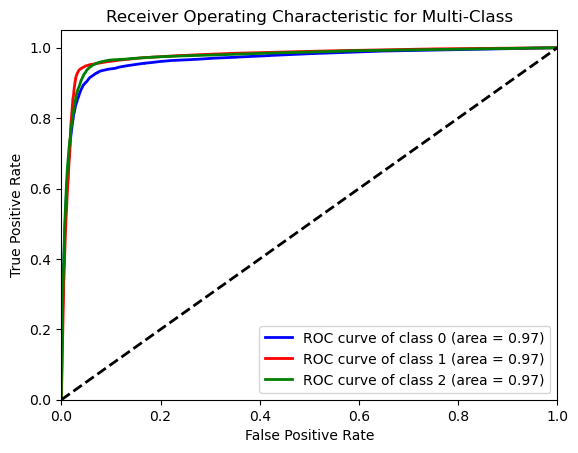

In [211]:
# ROC Curve for each class
fpr = {}
tpr = {}
roc_auc = {}

# Binarize the output
y_test_bin = label_binarize(y_test, classes=[0, 1, 2])
n_classes = y_test_bin.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve for each class
plt.figure()
colors = ['blue', 'red', 'green']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Multi-Class')
plt.legend(loc="lower right")
plt.show()

In [212]:
# Evaluate on the test set
test_score = rf_model.score(X_tf_idf_word_test, y_test)
print(f"Test set score: {test_score}")

Test set score: 0.9168959567224735


## Stock prediction

In [213]:
df = headlines[["Date","polarity_score","Stock Name"]]
 

In [214]:
df.shape

(214426, 3)

In [215]:
df["Stock Name"].value_counts()

AAPL    204772
AMZN      1300
ALB       1300
META      1300
MSFT      1296
SMCI      1100
NFLX      1100
NVDA      1100
AVGO      1098
TSLA        60
Name: Stock Name, dtype: int64

In [216]:
# Group by "Date" and "Stock Name" and calculate the mean of "sentence_score"
df_grouped = df.groupby(["Date", "Stock Name"]).mean().reset_index()

In [217]:
print(df_grouped.shape)

(1624, 3)


In [218]:
df_grouped.head()

,Date,Stock Name,polarity_score
0,2020-01-01,AAPL,-0.026744
1,2020-01-02,AAPL,-0.014264
2,2020-01-03,AAPL,-0.095656
3,2020-01-04,AAPL,-0.154935
4,2020-01-05,AAPL,-0.160336


In [219]:
df_grouped['Stock Name'].value_counts()

AAPL    1461
AVGO      30
NFLX      29
SMCI      29
META      24
ALB       21
AMZN      15
MSFT       9
NVDA       5
TSLA       1
Name: Stock Name, dtype: int64

In [220]:
df_grouped.columns

Index(['Date', 'Stock Name', 'polarity_score'], dtype='object')

In [221]:
Stock=pd.read_csv(stock_data_path)

In [222]:
print(Stock.shape)
Stock.head()

(2206, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2023-07-03,276.489990,284.250000,275.109985,279.820007,279.820007,119685900,TSLA
1,2023-07-05,278.820007,283.850006,277.600006,282.480011,282.480011,131530900,TSLA
2,2023-07-06,278.089996,279.970001,272.880005,276.540009,276.540009,120332100,TSLA
3,2023-07-07,278.429993,280.779999,273.769989,274.429993,274.429993,113602000,TSLA
4,2023-07-10,276.470001,277.519989,265.100006,269.609985,269.609985,119425400,TSLA


In [223]:
Stock['Stock Name'].value_counts()

AAPL    1006
TSLA     240
SMCI     240
AMZN     240
AVGO     240
ALB      240
Name: Stock Name, dtype: int64

In [224]:
Stock['Stock Name'].unique()

array(['TSLA', 'SMCI', 'AMZN', 'AVGO', 'ALB', 'AAPL'], dtype=object)

In [225]:
Stock["Date"]=pd.to_datetime(Stock["Date"])
Stock["Date"]=Stock["Date"].dt.date
print(Stock.shape)
Stock.head()

(2206, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2023-07-03,276.489990,284.250000,275.109985,279.820007,279.820007,119685900,TSLA
1,2023-07-05,278.820007,283.850006,277.600006,282.480011,282.480011,131530900,TSLA
2,2023-07-06,278.089996,279.970001,272.880005,276.540009,276.540009,120332100,TSLA
3,2023-07-07,278.429993,280.779999,273.769989,274.429993,274.429993,113602000,TSLA
4,2023-07-10,276.470001,277.519989,265.100006,269.609985,269.609985,119425400,TSLA


## Let's See affect of tweet on a specific stock

In [226]:
stk_name='AAPL'

In [227]:
stock = Stock[Stock["Stock Name"] == stk_name]
stock["Date"] = pd.to_datetime(stock["Date"])
stock["Date"] = stock["Date"].dt.date
# Reset the index of appl_stock
stock.reset_index(drop=True, inplace=True)
stock.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400,AAPL
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,AAPL
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200,AAPL
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,AAPL


In [228]:
stock.shape

(1006, 8)

In [229]:
# Now filter the grouped DataFrame for rows where 'Stock Name' is 'AAPL'
df = df_grouped[df_grouped['Stock Name'] == stk_name]
# Reset the index of appl_df
df.reset_index(drop=True, inplace=True)

In [230]:
print(df.shape)
df.head()

(1461, 3)


,Date,Stock Name,polarity_score
0,2020-01-01,AAPL,-0.026744
1,2020-01-02,AAPL,-0.014264
2,2020-01-03,AAPL,-0.095656
3,2020-01-04,AAPL,-0.154935
4,2020-01-05,AAPL,-0.160336


In [231]:
# Now perform the join operation
df = stock.join(df.set_index(["Date", "Stock Name"]), on=["Date", "Stock Name"], how="inner")
df.reset_index(drop=True, inplace=True)

In [232]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400,AAPL,-0.014264
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,AAPL,-0.095656
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200,AAPL,-0.078655
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL,-0.066492
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,AAPL,-0.062423


In [233]:
df.shape

(1006, 9)

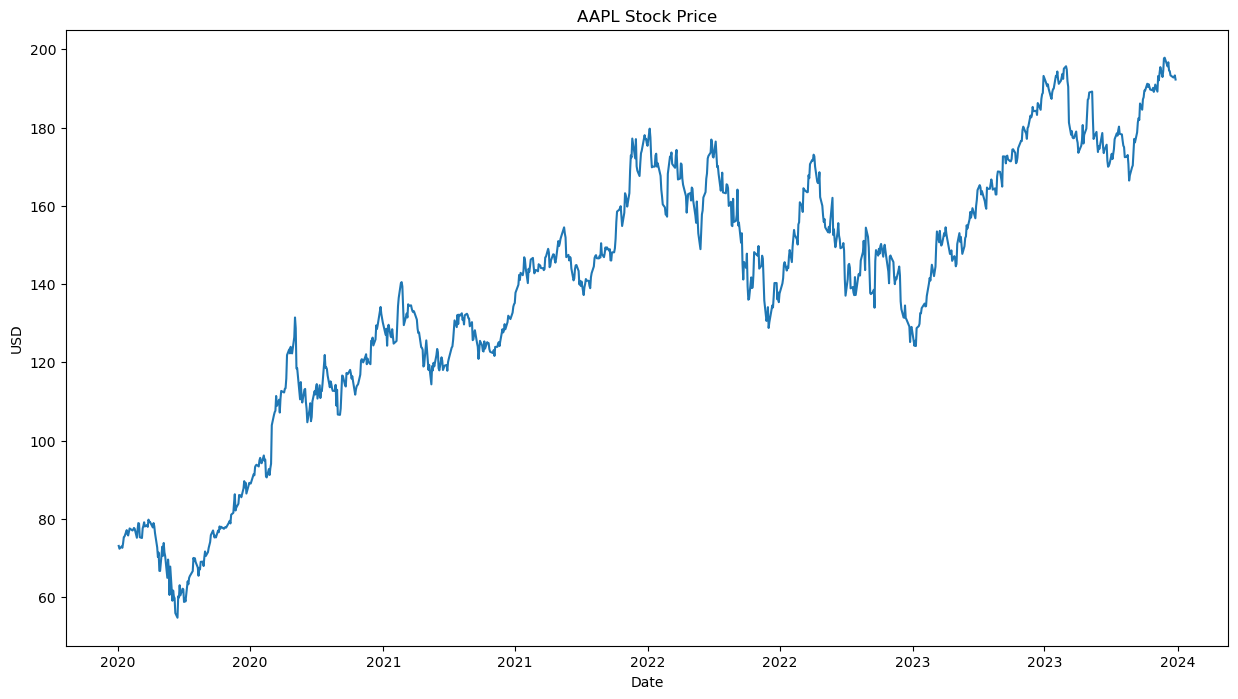

In [234]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["Adj Close"])
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

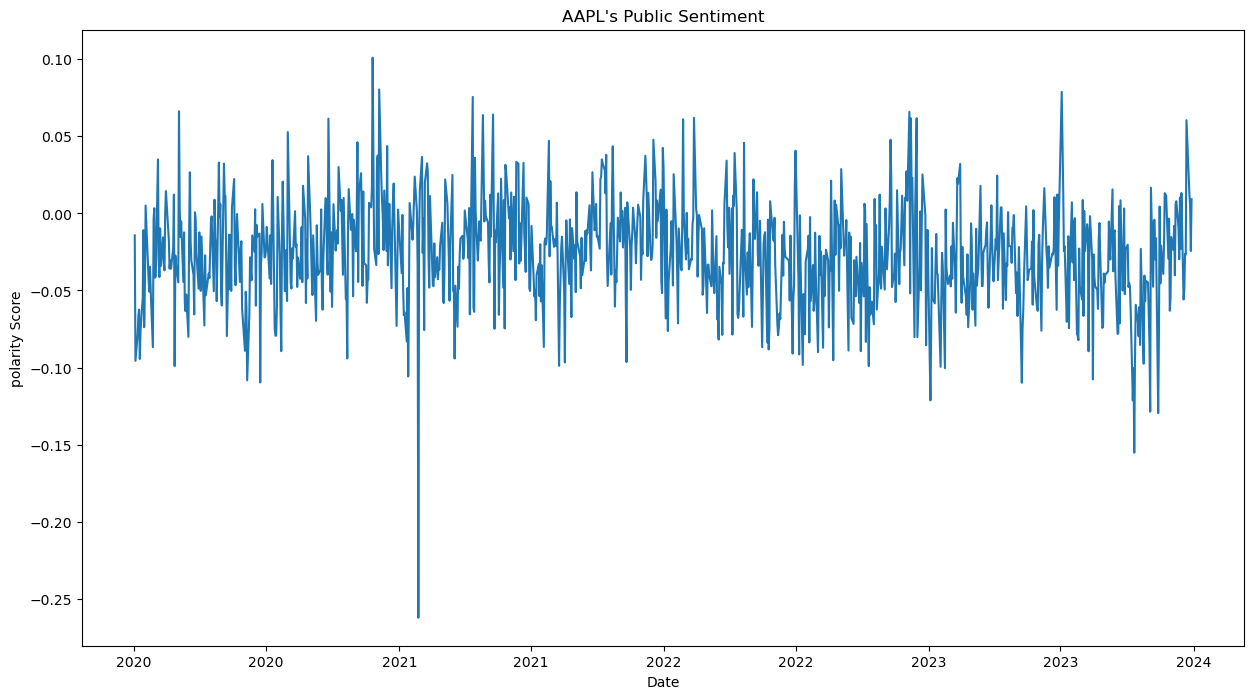

In [235]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(df["Date"], df["polarity_score"])
ax.set(xlabel="Date",ylabel="polarity Score",title=f"{stk_name}'s Public Sentiment")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [236]:
# fin_df = appl_df[["Date","Close","sentence_score"]]
fin_df=df
# fin_df = fin_df.reset_index(drop=True)
print(fin_df.shape)
fin_df.head()

(1006, 9)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400,AAPL,-0.014264
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,AAPL,-0.095656
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200,AAPL,-0.078655
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL,-0.066492
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,AAPL,-0.062423


In [237]:
def SentimentAdjustedMA(df, ma_days):
    def weight_multiplier(close,sent_score):
        maxi = max(close)
        mini = min(close)
        len_close = len(close)
        if len_close<2:
            interval = math.sqrt(close[0])
        else:
            interval = statistics.variance(close)
        max_var = interval
        weighted=0
        for i in range(len_close):
            if sent_score[i] < 0:
                weighted += close[i] + (2*sent_score[i]*max_var)
            else:
                weighted += close[i] + (sent_score[i]*max_var)
        return weighted/len_close-1
    samas = [df.loc[0,"Adj Close"]]
    rows = df.shape[0]
    for i in range(1,rows):
        if i < ma_days:
            mini_df = df.iloc[:i+1,:]
        elif i + ma_days >= rows:
            mini_df = df.iloc[i:,:]
        else:
            mini_df = df.iloc[i-ma_days+1:i+1,:]
        sama_value = weight_multiplier(mini_df["Adj Close"].tolist(),mini_df["polarity_score"].tolist())
        samas.append(sama_value)
    return samas

In [238]:
sma5= SentimentAdjustedMA(fin_df, ma_days=5)
fin_df["SMA(5)"] = sma5
sma20= SentimentAdjustedMA(fin_df, ma_days=10)
fin_df["SMA(20)"] = sma20
fin_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name,polarity_score,SMA(5),SMA(20)
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,73.059433,135480400,AAPL,-0.014264,73.059433,73.059433
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.349144,146322800,AAPL,-0.095656,71.676561,71.676561
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.925636,118387200,AAPL,-0.078655,71.760162,71.760162
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.582664,108872000,AAPL,-0.066492,71.715890,71.715890
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.750244,132079200,AAPL,-0.062423,71.896991,71.896991


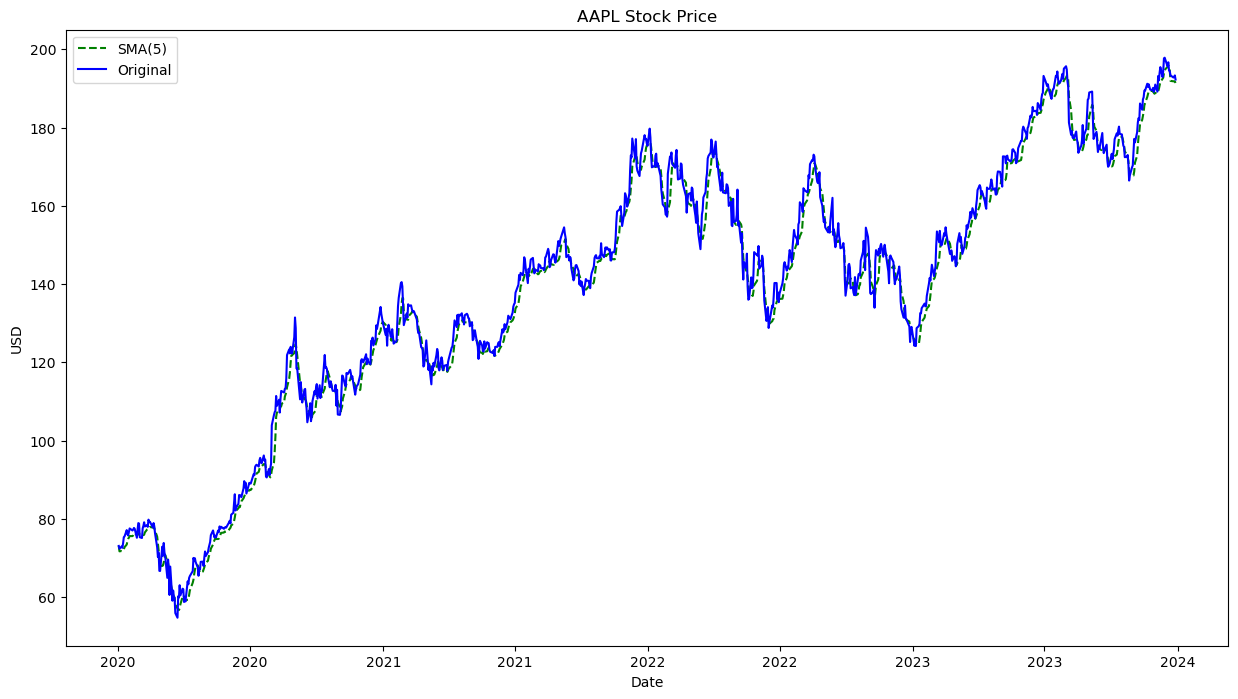

In [239]:
fig,ax = plt.subplots(figsize=(15,8))
ax.plot(fin_df["Date"], fin_df["SMA(5)"], label="SMA(5)", linestyle="--", color="g")
ax.plot(fin_df["Date"], fin_df["Adj Close"], label="Original", color="b")
ax.set(xlabel="Date",ylabel="USD",title=f"{stk_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.legend()
plt.show()

In [240]:
# Sort the dataframe by the 'Date' column
fin_df = fin_df.sort_values(by='Date')

# Reset the index to keep the dataframe tidy
fin_df = fin_df.reset_index(drop=True)

Final Portfolio Value: $83937.25
Sharpe Ratio: 1.76
Number of Trades Executed: 320
Win Ratio: 0.21


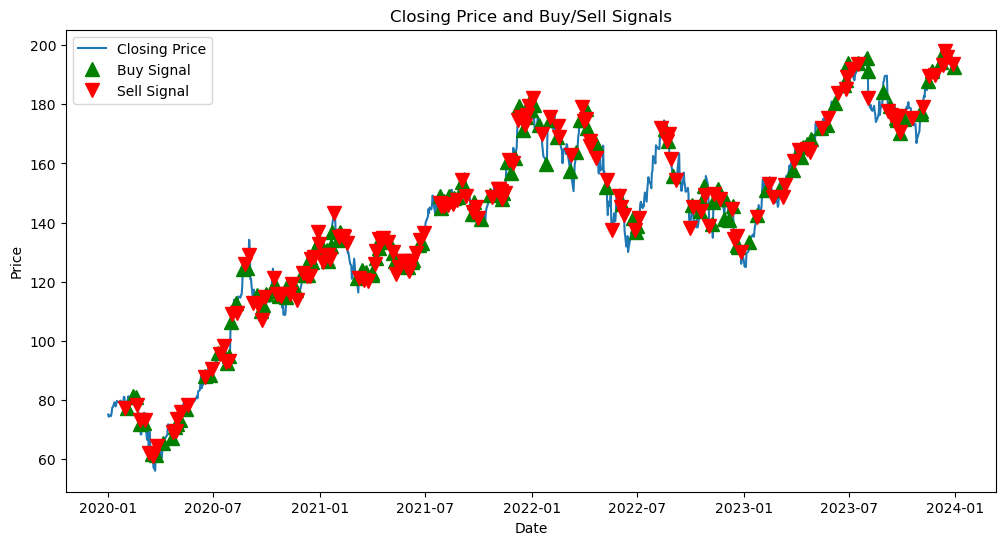

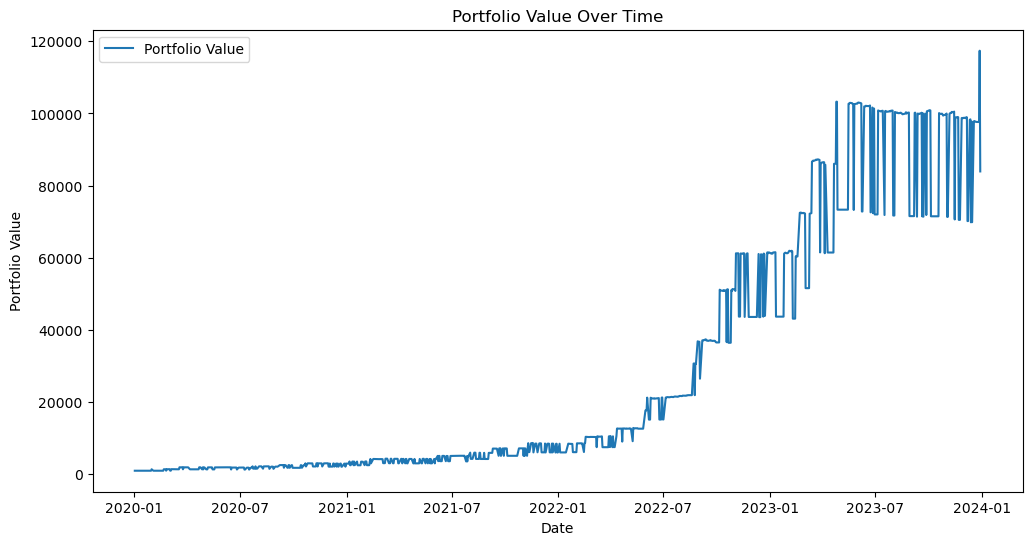

In [241]:
# Generate signals based on polarity score and additional filter (SMA)
def generate_signals(df):
    df['SMA'] = df['Close'].rolling(window=20).mean()  # 20-day simple moving average
    df['Signal'] = 0
    df['Signal'] = np.where((df['polarity_score'] > 0) & (df['Close'] > df['SMA']), 1, df['Signal'])
    df['Signal'] = np.where((df['polarity_score'] < 0) & (df['Close'] < df['SMA']), -1, df['Signal'])
    df['Order'] = df['Signal'].diff()
    return df

# Calculate returns and performance metrics with stop-loss, take-profit, and position sizing
def calculate_performance(df, initial_cash=1000, stop_loss_pct=0.10, take_profit_pct=0.20, position_size_pct=0.20):
    cash = initial_cash
    position = 0
    purchase_price = 0
    portfolio_values = []
    
    for index, row in df.iterrows():
        if row['Order'] == -1 and cash > 0:  # Buy signal
            position = (cash * position_size_pct) / row['Close']
            cash += position * row['Close']
            purchase_price = row['Close']
        elif row['Order'] == 1 and position > 0:  # Sell signal
            cash -= position * row['Close']
            position = 0
        elif position > 0:
            if row['Close'] < purchase_price * (1 - stop_loss_pct):  # Stop-loss condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to stop-loss
            elif row['Close'] > purchase_price * (1 + take_profit_pct):  # Take-profit condition
                cash += position * row['Close']
                position = 0
                df.loc[index, 'Order'] = -1  # Mark this as a sell due to take-profit

        portfolio_value = cash + position * row['Close']
        portfolio_values.append(portfolio_value)

    df['Portfolio Value'] = portfolio_values
    final_portfolio_value = portfolio_values[-1]
    returns = df['Portfolio Value'].pct_change().dropna()
    sharpe_ratio = (252**0.5) * returns.mean() / returns.std()  # Assuming 252 trading days in a year
    total_trades = len(df[df['Order'].abs() == 1])
    winning_trades = len(df[(df['Order'] == -1) & (df['Close'] > df['Close'].shift(1))])
    win_ratio = winning_trades / total_trades if total_trades > 0 else 0

    performance = {
        "Final Portfolio Value": final_portfolio_value,
        "Sharpe Ratio": sharpe_ratio,
        "Number of Trades Executed": total_trades,
        "Win Ratio": win_ratio
    }

    return performance

# Load your dataframe
# Ensure that the 'Date' column is in datetime format and sort by date
fin_df['Date'] = pd.to_datetime(fin_df['Date'])
fin_df = fin_df.sort_values(by='Date')

# Generate signals and calculate performance
fin_df = generate_signals(fin_df)
performance = calculate_performance(fin_df)

# Print performance metrics
print(f"Final Portfolio Value: ${performance['Final Portfolio Value']:.2f}")
print(f"Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")
print(f"Number of Trades Executed: {performance['Number of Trades Executed']}")
print(f"Win Ratio: {performance['Win Ratio']:.2f}")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(fin_df['Date'], fin_df['Close'], label='Closing Price')

# Plot buy signals
buy_signals = fin_df[fin_df['Order'] == 1]
plt.plot(buy_signals['Date'], buy_signals['Close'], '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
sell_signals = fin_df[fin_df['Order'] == -1]
plt.plot(sell_signals['Date'], sell_signals['Close'], 'v', markersize=10, color='r', label='Sell Signal')

plt.title('Closing Price and Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot portfolio value
plt.figure(figsize=(12, 6))
plt.plot(fin_df['Date'], fin_df['Portfolio Value'], label='Portfolio Value')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.show()

final_path=work_directory+"/signals.csv"
fin_df.to_csv('final_path', index=False)  # Adjust the path to your desired output file location




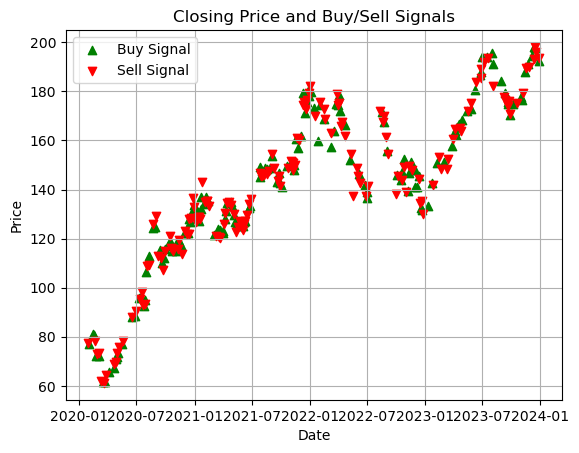

In [242]:
# Plot buy signals
buy_signals = fin_df[fin_df['Order'] == 1]
plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', color='green', label='Buy Signal', alpha=1)

# Plot sell signals
sell_signals = fin_df[fin_df['Order'] == -1]
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', color='red', label='Sell Signal', alpha=1)

plt.title('Closing Price and Buy/Sell Signals')
plt.xlabel('Date')


plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

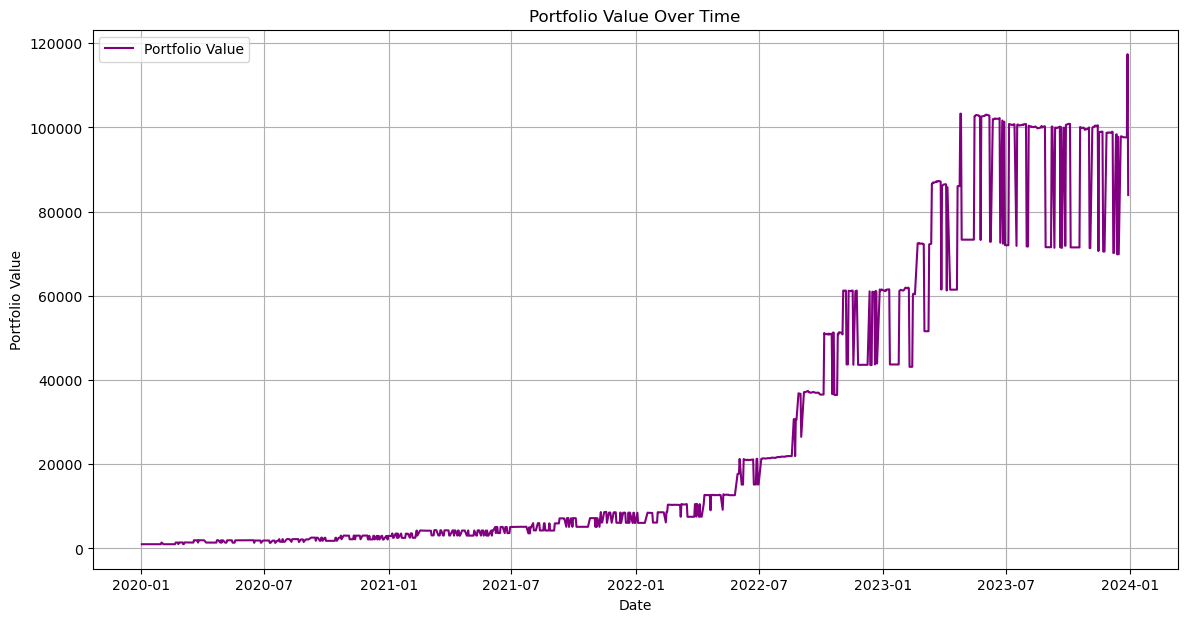

Final Portfolio Value: $83937.25
Sharpe Ratio: 1.76
Number of Trades Executed: 320
Win Ratio: 0.21


In [243]:
# Plotting the Portfolio Value over Time
plt.figure(figsize=(14, 7))
plt.plot(fin_df['Date'], fin_df['Portfolio Value'], label='Portfolio Value', color='purple')
plt.title('Portfolio Value Over Time')
plt.xlabel('Date')
plt.ylabel('Portfolio Value')
plt.legend()
plt.grid()
plt.show()

# Print performance metrics
print(f"Final Portfolio Value: ${performance['Final Portfolio Value']:.2f}")
print(f"Sharpe Ratio: {performance['Sharpe Ratio']:.2f}")
print(f"Number of Trades Executed: {performance['Number of Trades Executed']}")
print(f"Win Ratio: {performance['Win Ratio']:.2f}")